To Do:<br>
- Add more Broker Dealers
- Update the XML link for Schwab 2024 on, they changed their direct html

# Data Ingestion

In [1]:
#adjustable
years = ["2022", "2023", "2024"]
quarters = ["Q1", "Q2", "Q3", "Q4"]

In [2]:
from typing import List, Dict
#FIDELITY
#given link pull the XML file's data
#FBS/NFS
#Link Sample: https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/nfs-q4-2024.xml

def build_fidelity_links(
    years: List[str],
    quarters: List[str],
    prefixes: List[str] = ["fbs", "nfs"]
) -> List[Dict[str, str]]:

    base_url = "https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/{filename}.xml"
    links = []

    for prefix in prefixes:
        for year in years:
            for quarter in quarters:
                filename = f"{prefix}-{quarter.lower()}-{year}"
                url = base_url.format(filename=filename)
                firm_name = "Fidelity Brokerage Services LLC" if prefix == "fbs" else "National Financial Services LLC"

                links.append({
                    "url": url,
                    "firm": firm_name,
                    "quarter": quarter,
                    "year": year
                })

    return links



In [3]:
#SCHWAB
#given link pull the XML file's data
#Link Sample (pre-2024): https://public.s3.com/rule606/chas/606-CHAS-2020Q2.xml
#Link Sample (2024 +) : https://content.schwab.com/drupal_dependencies/psr/606/2025-Q1-Schwab-Quarterly-Report.xml
def build_schwab_links(
    years: List[str],
    quarters: List[str]
) -> List[Dict[str, str]]:

    base_url = "https://public.s3.com/rule606/chas/{filename}.xml"
    links = []

    for year in years:
        for quarter in quarters:
            filename = f"606-CHAS-{year}{quarter}"
            url = base_url.format(filename=filename)

            links.append({
                "url": url,
                "firm": "Charles Schwab",
                "quarter": quarter,
                "year": year
            })

    return links

In [4]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from typing import List, Dict, Any

#parse out XML elements
def extract_data_from_xml(
    url: str,
    firm: str,
    quarter: str,
    year: str,
    check_status: bool = True,
    verbose: bool = False
) -> List[Dict[str, Any]]:

    # Helper to parse individual venue element
    def parse_venue_data(rvenue, category, month):
        return {
            "firm": firm,
            "quarter": quarter,
            "year": year,
            "month": month,
            "category": category,
            # XML tags mapped to dictionary fields
            "venue_name": rvenue.findtext("name"),
            "mpid": rvenue.findtext("mic"),
            "order_pct": rvenue.findtext("orderPct"),
            "market_pct": rvenue.findtext("marketPct"),
            "marketable_limit_pct": rvenue.findtext("marketableLimitPct"),
            "non_marketable_limit_pct": rvenue.findtext("nonMarketableLimitPct"),
            "other_pct": rvenue.findtext("otherPct"),
            "net_pmt_paid_recv_market_orders_usd": rvenue.findtext("netPmtPaidRecvMarketOrdersUsd"),
            "net_pmt_paid_recv_market_orders_cph": rvenue.findtext("netPmtPaidRecvMarketOrdersCph"),
            "net_pmt_paid_recv_marketable_limit_orders_usd": rvenue.findtext("netPmtPaidRecvMarketableLimitOrdersUsd"),
            "net_pmt_paid_recv_marketable_limit_orders_cph": rvenue.findtext("netPmtPaidRecvMarketableLimitOrdersCph"),
            "net_pmt_paid_recv_non_marketable_limit_orders_usd": rvenue.findtext("netPmtPaidRecvNonMarketableLimitOrdersUsd"),
            "net_pmt_paid_recv_non_marketable_limit_orders_cph": rvenue.findtext("netPmtPaidRecvNonMarketableLimitOrdersCph"),
            "net_pmt_paid_recv_other_orders_usd": rvenue.findtext("netPmtPaidRecvOtherOrdersUsd"),
            "net_pmt_paid_recv_other_orders_cph": rvenue.findtext("netPmtPaidRecvOtherOrdersCph"),
            "material_aspects": rvenue.findtext("materialAspects"),
        }

    # Request XML file from URL
    response = requests.get(url)

    # For Schwab only: check response status
    if check_status and response.status_code != 200:
        if verbose:
            print(f"[WARNING] Failed to fetch {url} - Status: {response.status_code}")
        return []

    # Parse XML
    root = ET.fromstring(response.content)
    data = []

    # Loop over each reporting month block
    for rmonthly in root.findall(".//rMonthly"):
        month = rmonthly.findtext("mon")

        # Loop over each product category (stocks, options)
        for category_tag, category_name in [
            ("rSP500", "SP500"),
            ("rOtherStocks", "OtherStocks"), #non SP500
            ("rOptions", "Options"),
        ]:
            section = rmonthly.find(category_tag)
            if section is not None:
                # Loop over each execution venue inside category
                for rvenue in section.findall(".//rVenue"):
                    venue_data = parse_venue_data(rvenue, category_name, month)
                    data.append(venue_data)

    # Log # of rows extracted
    if verbose:
        print(f"[INFO] Extracted {len(data)} records from {url}")

    return data


#extract the data
def process_links_to_dataframe(
    links: List[Dict[str, Any]],
    check_status: bool = True,
    verbose: bool = False
) -> pd.DataFrame:

    all_data = []

    # Loop through each document link and extract data
    for link in links:
        url = link["url"]
        firm = link["firm"]
        quarter = link["quarter"]
        year = link["year"]

        data = extract_data_from_xml(url, firm, quarter, year, check_status, verbose)
        all_data.extend(data)

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    # # Drop 'month' column if exists
    # if 'month' in df.columns:
    #     df = df.drop(columns=['month'])

    if verbose:
        print(f"[INFO] Final DataFrame shape: {df.shape}")

    return df

#convert to categorical
def convert_data_types(
    df: pd.DataFrame,
    numeric_columns: List[str] = None,
    categorical_columns: List[str] = None,
    verbose: bool = False
) -> pd.DataFrame:

    if categorical_columns is None:
        categorical_columns = ['firm', 'quarter', 'category', 'year', 'venue_name', 'mpid']

    # Categorical conversion
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
            if verbose:
                print(f"[INFO] Converted {col} to categorical.")

    return df


In [5]:
#function to make numeric since with change in dataframe combination becomes object. this will make it numeric
numeric_columns = [
    'order_pct', 'market_pct', 'marketable_limit_pct',
    'non_marketable_limit_pct', 'other_pct',
    'net_pmt_paid_recv_market_orders_usd', 'net_pmt_paid_recv_market_orders_cph',
    'net_pmt_paid_recv_marketable_limit_orders_usd', 'net_pmt_paid_recv_marketable_limit_orders_cph',
    'net_pmt_paid_recv_non_marketable_limit_orders_usd', 'net_pmt_paid_recv_non_marketable_limit_orders_cph',
    'net_pmt_paid_recv_other_orders_usd', 'net_pmt_paid_recv_other_orders_cph'
]

def force_numeric_columns(df: pd.DataFrame, columns: List[str], verbose: bool = False) -> pd.DataFrame:

    df = df.copy()

    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if verbose:
                print(f"[INFO] Column '{col}' forced to numeric.")
        else:
            if verbose:
                print(f"[WARNING] Column '{col}' not found in DataFrame.")

    return df

In [6]:

links_fidelity = build_fidelity_links(years, quarters)
links_schwab = build_schwab_links(years, quarters)

df_fidelity = process_links_to_dataframe(links_fidelity, check_status=False, verbose=True)
df_schwab = process_links_to_dataframe(links_schwab, check_status=True, verbose=True)


[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q1-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q2-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q3-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q4-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q1-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q2-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q3-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q4-2023.xml
[INFO] E

In [7]:
df_schwab_test = df_schwab[df_schwab['year']== '2022']
df_schwab_test
df_schwab_test.to_csv("df_schwab_test.csv", index=False)
df_schwab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 21 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   firm                                               468 non-null    object
 1   quarter                                            468 non-null    object
 2   year                                               468 non-null    object
 3   month                                              468 non-null    object
 4   category                                           468 non-null    object
 5   venue_name                                         468 non-null    object
 6   mpid                                               0 non-null      object
 7   order_pct                                          468 non-null    object
 8   market_pct                                         468 non-null    object
 9   marketable_limit_pct 

# Data Cleaning & Feature Engineering

In [8]:
combined_monthly = pd.concat([df_fidelity, df_schwab], ignore_index=True)

combined_monthly = force_numeric_columns(combined_monthly, numeric_columns, verbose=True)


[INFO] Column 'order_pct' forced to numeric.
[INFO] Column 'market_pct' forced to numeric.
[INFO] Column 'marketable_limit_pct' forced to numeric.
[INFO] Column 'non_marketable_limit_pct' forced to numeric.
[INFO] Column 'other_pct' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_market_orders_usd' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_market_orders_cph' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_marketable_limit_orders_usd' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_marketable_limit_orders_cph' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_non_marketable_limit_orders_usd' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_non_marketable_limit_orders_cph' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_other_orders_usd' forced to numeric.
[INFO] Column 'net_pmt_paid_recv_other_orders_cph' forced to numeric.


# Quarterly Fields

In [9]:
def collapse_monthly_to_quarterly(df):
    """
    Converts monthly Rule 606 data to quarterly by safe aggregation.

    Averages routing % columns across months.
    Sums payment + CPH columns across months.
    Keeps identifying columns as first value.
    """

    # Define columns
    routing_pct_cols = [
        'order_pct', 'market_pct', 'marketable_limit_pct',
        'non_marketable_limit_pct', 'other_pct'
    ]

    payment_cols = [
        'net_pmt_paid_recv_market_orders_usd',
        'net_pmt_paid_recv_marketable_limit_orders_usd',
        'net_pmt_paid_recv_non_marketable_limit_orders_usd',
        'net_pmt_paid_recv_other_orders_usd',
        'net_pmt_paid_recv_market_orders_cph',
        'net_pmt_paid_recv_marketable_limit_orders_cph',
        'net_pmt_paid_recv_non_marketable_limit_orders_cph',
        'net_pmt_paid_recv_other_orders_cph'
    ]

    id_cols = ['firm', 'quarter', 'year', 'category', 'venue_name']

    # Convert numerics (object → float)
    for col in routing_pct_cols + payment_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Group and aggregate
    df_quarterly = df.groupby(id_cols).agg(
        {**{col: 'mean' for col in routing_pct_cols},
         **{col: 'sum' for col in payment_cols},
         'material_aspects': 'first',
         'mpid': 'first'}
    ).reset_index()

    return df_quarterly

combined_quarterly = collapse_monthly_to_quarterly(combined_monthly)
#combined_quarterly_quarterly.to_csv('combined_quarterly_quarterly.csv')


# Monthly Fields

In [10]:
#prepare venue_name field for one-hot encoding
#get the venue_name field, do lowercase for everything
combined_quarterly['std_venue_name'] = combined_quarterly[['venue_name']]
combined_quarterly['std_venue_name'] = combined_quarterly['std_venue_name'].str.lower()

#remove commas and periods
combined_quarterly['std_venue_name'] = combined_quarterly['std_venue_name'].str.replace(',', '')
combined_quarterly['std_venue_name'] = combined_quarterly['std_venue_name'].str.replace('.', '')
combined_quarterly['std_venue_name'] = combined_quarterly['std_venue_name'].str.replace(' ', '')

combined_quarterly.drop_duplicates(inplace=True)


In [11]:
#create columns for total payment to firm & number of shares sent to venue

import numpy as np
import pandas as pd

#estimates # of shares sent to venues by pmt usd/cph
#cph = cents per hundred shares so * 100
#usd = so to translate to cents = 100
#use 100*100

def estimate_shares_batch(df: pd.DataFrame, column_pairs: dict) -> pd.DataFrame:

    df = df.copy()  # avoid modifying original DataFrame

    for usd_col, cph_col in column_pairs.items():
        # Clean naming for output column
        output_col = usd_col.replace('net_pmt_paid_recv_', '')
        output_col = output_col.replace('_usd', '')
        output_col = f"estimated_{output_col}_shares"

        # Only calculate where both values exist and cph is non-zero
        valid = (
            (df[cph_col] != 0) & df[cph_col].notnull() & df[usd_col].notnull())

        df[output_col] = np.nan  # initialize with NaN
        df.loc[valid, output_col] = (df.loc[valid, usd_col] * 10000) / df.loc[valid, cph_col]

    return df

column_pairs = {
    'net_pmt_paid_recv_market_orders_usd': 'net_pmt_paid_recv_market_orders_cph',
    'net_pmt_paid_recv_marketable_limit_orders_usd': 'net_pmt_paid_recv_marketable_limit_orders_cph',
    'net_pmt_paid_recv_non_marketable_limit_orders_usd': 'net_pmt_paid_recv_non_marketable_limit_orders_cph',
    'net_pmt_paid_recv_other_orders_usd': 'net_pmt_paid_recv_other_orders_cph'
}

combined_quarterly = estimate_shares_batch(combined_quarterly, column_pairs)


In [12]:
columns_to_sum_pmt = [
    'net_pmt_paid_recv_market_orders_usd',
    'net_pmt_paid_recv_marketable_limit_orders_usd',
    'net_pmt_paid_recv_non_marketable_limit_orders_usd',
    'net_pmt_paid_recv_other_orders_usd'
]

columns_to_sum_shares = [
    'estimated_market_orders_shares',
    'estimated_marketable_limit_orders_shares',
    'estimated_non_marketable_limit_orders_shares',
    'estimated_other_orders_shares'
]

#total payment from PFOF to firm
combined_quarterly['total_pmt'] = combined_quarterly[columns_to_sum_pmt].sum(axis=1)
#estimated total shares sent to venue from calculation
combined_quarterly['est_total_shares'] = combined_quarterly[columns_to_sum_shares].sum(axis=1)

combined_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 27 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   firm                                               852 non-null    object 
 1   quarter                                            852 non-null    object 
 2   year                                               852 non-null    object 
 3   category                                           852 non-null    object 
 4   venue_name                                         852 non-null    object 
 5   order_pct                                          852 non-null    float64
 6   market_pct                                         852 non-null    float64
 7   marketable_limit_pct                               852 non-null    float64
 8   non_marketable_limit_pct                           852 non-null    float64
 9   other_pct 

In [13]:
#add column to calculate effective cents per share
#Effective CPH Estimated = total payment divided by estimated shares routed, providing an approximate weighted average payment or rebate per share (cents).
#decided to do this bc when i average all the cph, the total pmt was negative but the average of the cph was positive, so It reflects the true weighted average payment or fee per share across all order types and venues for each group (positive payment, negative payment, or no payment).
#This approach is considered more realistic than simply averaging the reported cph columns, because it accounts for the overall dollar amount relative to the estimated trading volume.
#It is the best possible approximation of actual execution costs or rebates using public Rule 606 data.

import numpy as np

def calculate_effective_cph(df, total_pmt_col='total_pmt', shares_col='est_total_shares', new_col='effective_cph_estimated'):

    # Calculate effective cents-per-share
    df[new_col] = df.apply(lambda row: np.nan if (
        #if any of these is 0 then put 0 in the new column
            pd.isna(row[total_pmt_col]) or
            pd.isna(row[shares_col]) or
            row[shares_col] == 0 or
            row[total_pmt_col] == 0
        #otherwise, put the effective cents
        ) else (row[total_pmt_col] / row[shares_col]) * 100,
        axis=1
    )

    return df

combined_quarterly = calculate_effective_cph(combined_quarterly)



##EDA

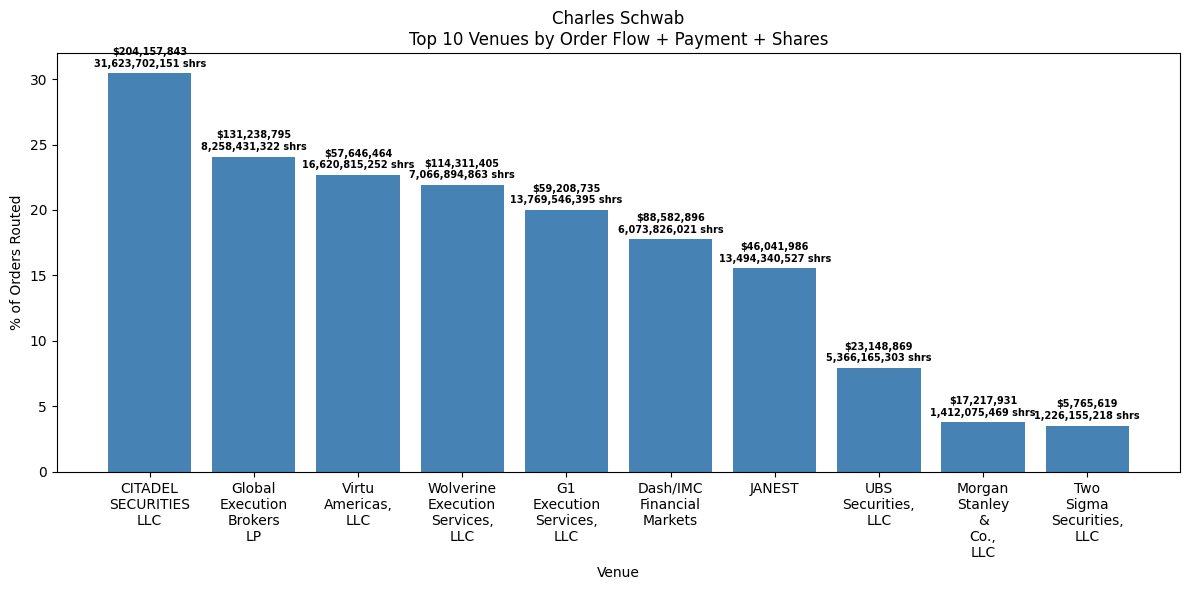

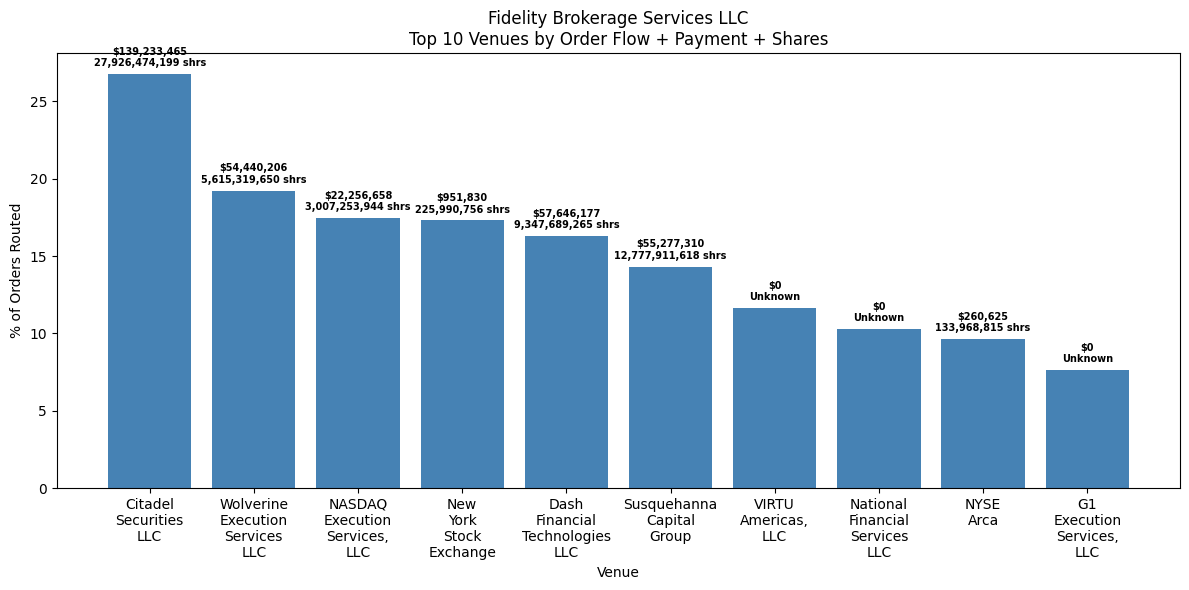

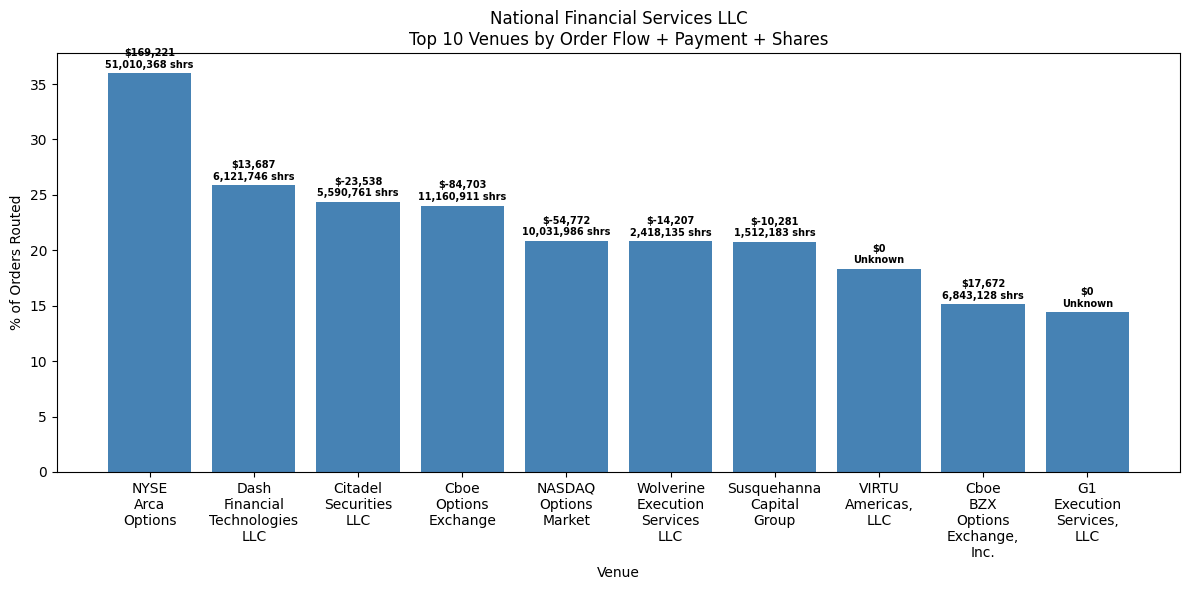

In [14]:
#Distribution of routing percentages across venues

import matplotlib.pyplot as plt

def plot_broker_top10_venues_with_payments_and_shares(df):

    for broker in df['firm'].unique():
        broker_data = df[df['firm'] == broker]

        top_venues = broker_data.groupby('venue_name')['order_pct'].mean().sort_values(ascending=False).head(10).index.tolist()
        filtered = broker_data[broker_data['venue_name'].isin(top_venues)]

        plot_data = filtered.groupby('venue_name').agg(
            avg_order_pct=('order_pct', 'mean'),
            total_payment=('total_pmt', 'sum'),
            total_shares=('est_total_shares', 'sum')
        ).reset_index().sort_values('avg_order_pct', ascending=False)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(plot_data['venue_name'], plot_data['avg_order_pct'], color='steelblue')

        plt.xlabel('Venue')
        plt.ylabel('% of Orders Routed')
        plt.title(f'{broker}\nTop 10 Venues by Order Flow + Payment + Shares')

        for bar, payment, shares in zip(bars, plot_data['total_payment'], plot_data['total_shares']):
            # 0 shares = unknown
            shares_label = f"{shares:,.0f} shrs" if shares != 0 else "Unknown"

            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,
                f"${payment:,.0f}\n{shares_label}",
                ha='center',
                fontsize=7,
                weight='bold'
            )

        plt.xticks(
            ticks=range(len(plot_data['venue_name'])),
            labels=[venue.replace(' ', '\n') for venue in plot_data['venue_name']]
        )

        plt.tight_layout()
        plt.show()

plot_broker_top10_venues_with_payments_and_shares(combined_quarterly)

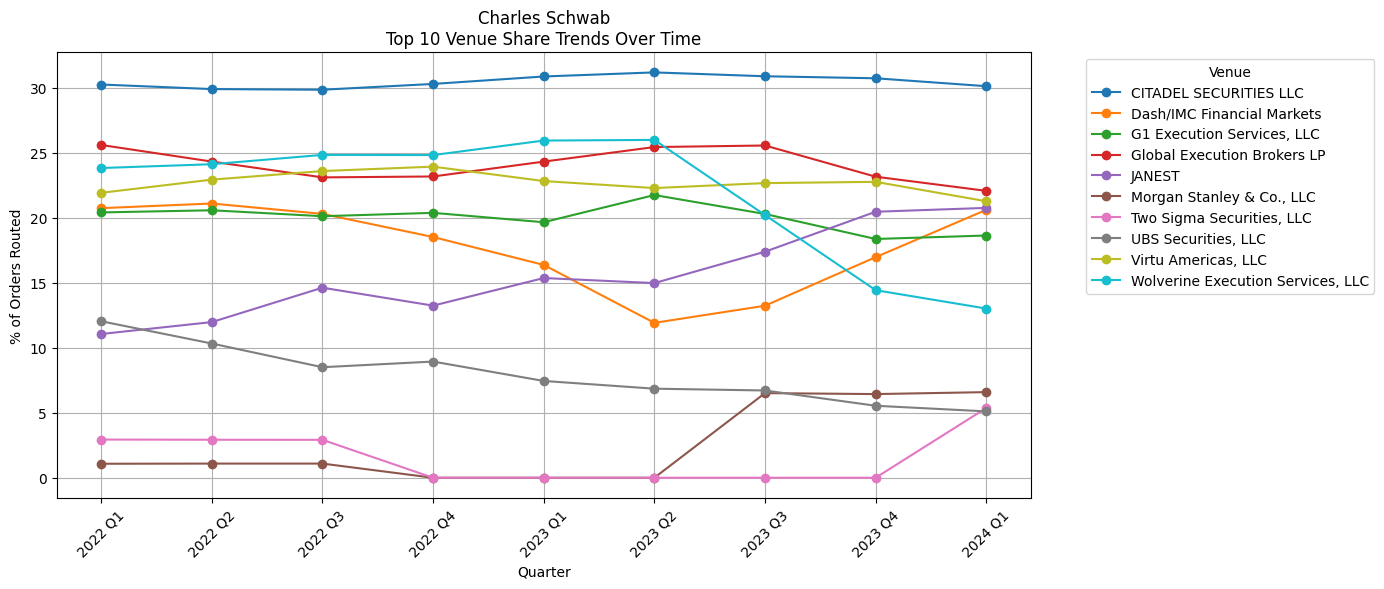

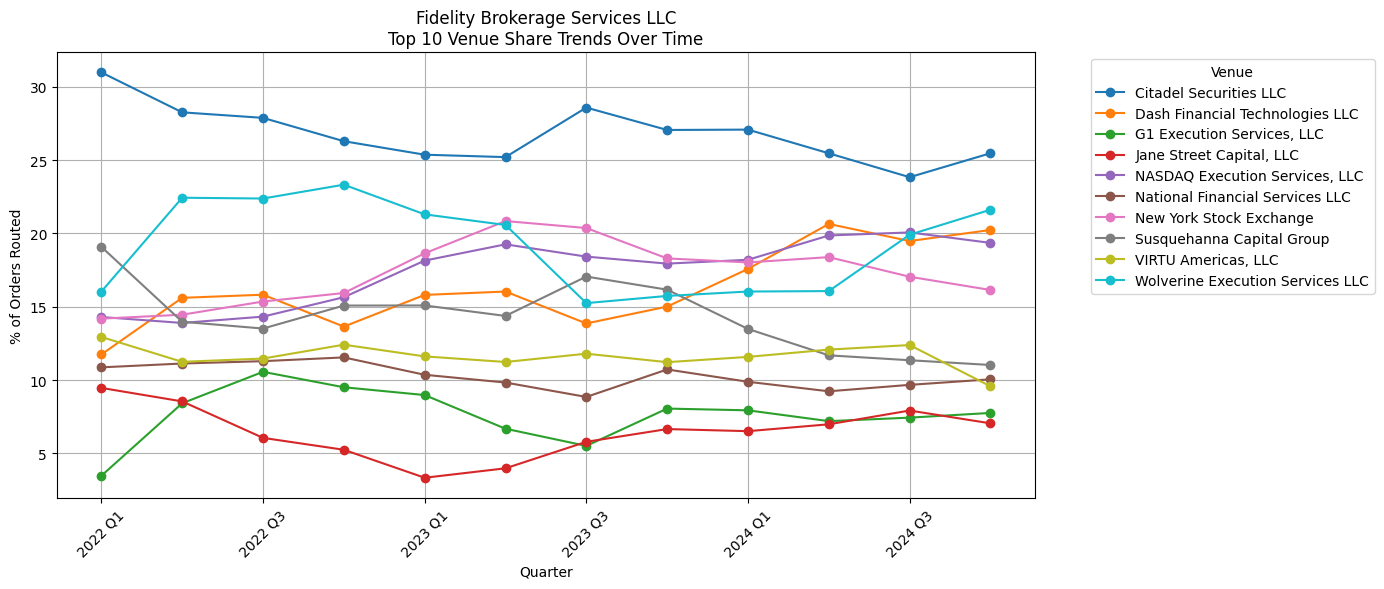

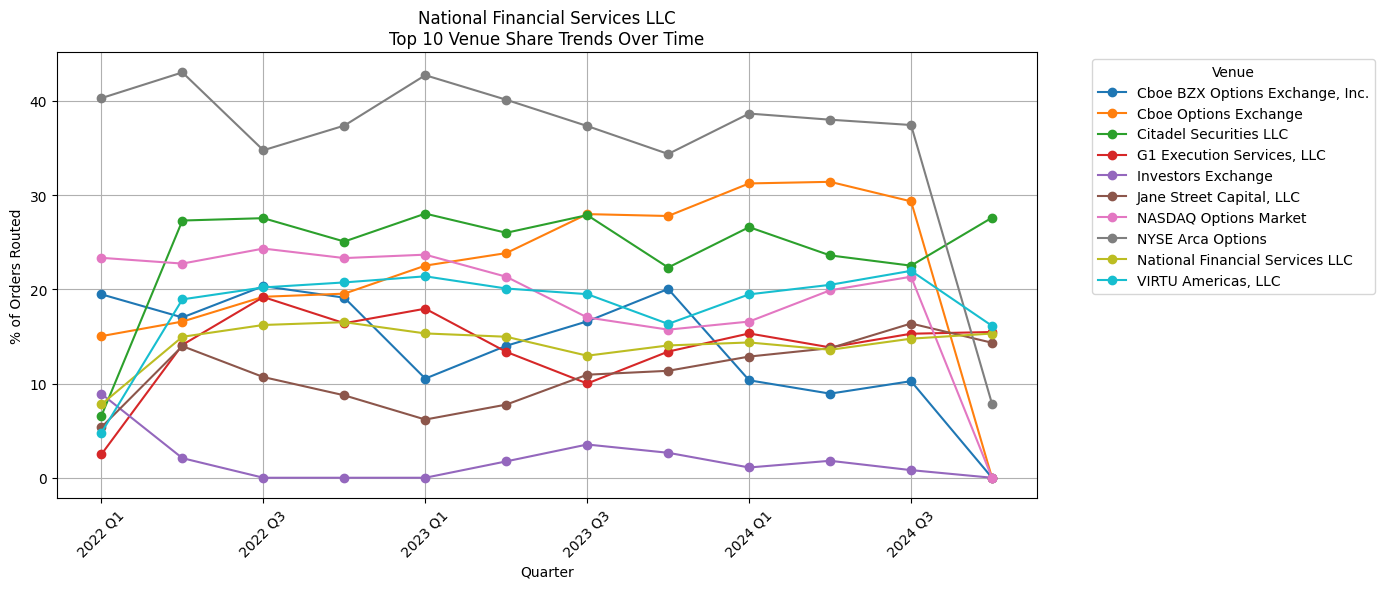

In [15]:
#Distribution of routing percentages across venues over time

def plot_broker_top10_venue_share_trends(df):

    df['time_period'] = df['year'].astype(str) + " " + df['quarter']

    for broker in df['firm'].unique():
        broker_data = df[df['firm'] == broker]

        # Find broker's top 10 venues overall
        top_venues = (
            broker_data.groupby('venue_name')['order_pct']
            .sum().sort_values(ascending=False).head(10).index.tolist()
        )

        # Filter to only those venues
        filtered = broker_data[broker_data['venue_name'].isin(top_venues)]

        # Pivot: venue share by time
        pivot = (
            filtered.groupby(['time_period', 'venue_name'])['order_pct']
            .mean().reset_index()
            .pivot(index='time_period', columns='venue_name', values='order_pct')
            .fillna(0)
        )

        # Plot
        plt.figure(figsize=(14, 6))
        pivot.plot(ax=plt.gca(), marker='o')

        plt.title(f"{broker}\nTop 10 Venue Share Trends Over Time")
        plt.xlabel("Quarter")
        plt.ylabel("% of Orders Routed")
        plt.xticks(rotation=45)
        plt.legend(title="Venue", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_broker_top10_venue_share_trends(combined_quarterly)


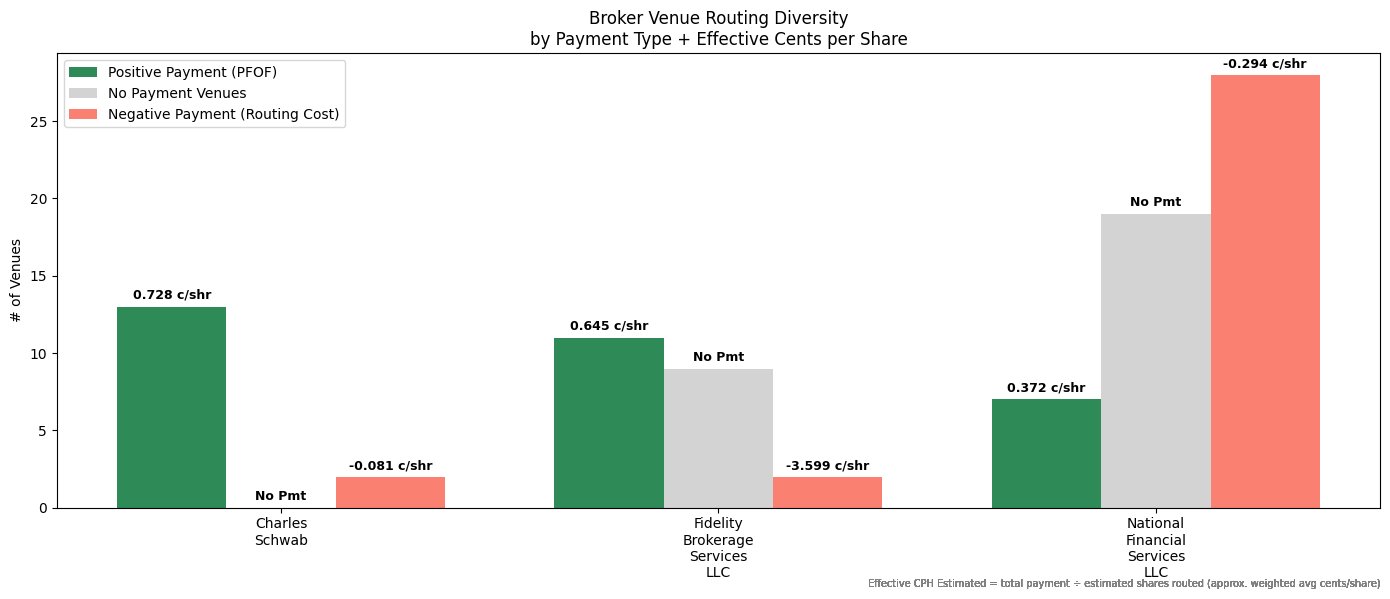

In [16]:
#payment types by broker

import matplotlib.pyplot as plt
import numpy as np

def plot_broker_venue_diversity_by_payment_type_with_effective_cph(df):

    brokers = df['firm'].unique()
    pos_counts = []
    zero_counts = []
    neg_counts = []
    pos_cph = []
    zero_cph = []
    neg_cph = []

    for broker in brokers:
        broker_data = df[df['firm'] == broker]

        # Positive payment group
        pos_data = broker_data[broker_data['total_pmt'] > 0]
        pos_counts.append(pos_data['venue_name'].nunique())
        pos_cph.append(pos_data['effective_cph_estimated'].mean())

        # No payment group
        zero_data = broker_data[broker_data['total_pmt'] == 0]
        zero_counts.append(zero_data['venue_name'].nunique())
        zero_cph.append(zero_data['effective_cph_estimated'].mean())

        # Negative payment group
        neg_data = broker_data[broker_data['total_pmt'] < 0]
        neg_counts.append(neg_data['venue_name'].nunique())
        neg_cph.append(neg_data['effective_cph_estimated'].mean())

    # Plot → order: pos, zero, neg
    x = np.arange(len(brokers))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))
    bars_pos = ax.bar(x - width, pos_counts, width, label='Positive Payment (PFOF)', color='seagreen')
    bars_zero = ax.bar(x, zero_counts, width, label='No Payment Venues', color='lightgray')
    bars_neg = ax.bar(x + width, neg_counts, width, label='Negative Payment (Routing Cost)', color='salmon')

    ax.set_ylabel('# of Venues')
    ax.set_title('Broker Venue Routing Diversity\nby Payment Type + Effective Cents per Share')
    ax.set_xticks(x)
    ax.set_xticklabels([broker.replace(' ', '\n') for broker in brokers])
    ax.legend()

    # Annotate avg CPH for each bar
    for bar_list, cph_list in zip([bars_pos, bars_zero, bars_neg], [pos_cph, zero_cph, neg_cph]):
        for bar, cph in zip(bar_list, cph_list):
            height = bar.get_height()
            if np.isnan(cph):
                label = "No Pmt"
            else:
                label = f"{cph:.3f} c/shr"

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                label,
                ha='center',
                fontsize=9,
                weight='bold'
            )
            fig.text(
              0.99, 0.01,
              "Effective CPH Estimated = total payment ÷ estimated shares routed (approx. weighted avg cents/share)",
              ha='right', va='bottom',
              fontsize=7, color='gray'
          )



    plt.tight_layout()
    plt.show()

plot_broker_venue_diversity_by_payment_type_with_effective_cph(combined_quarterly)


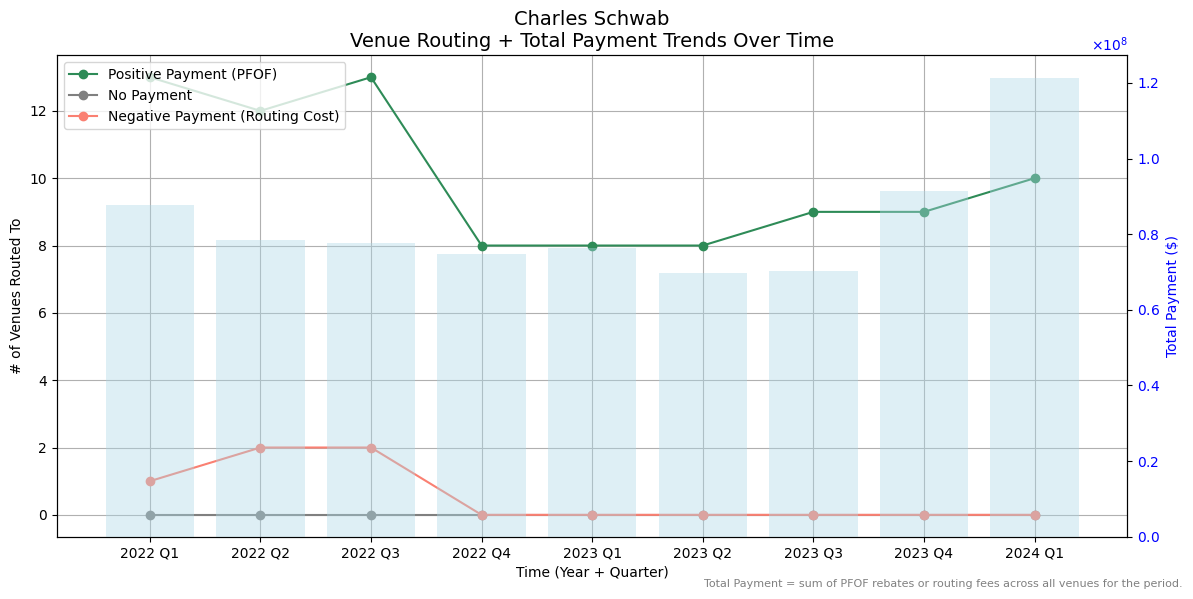

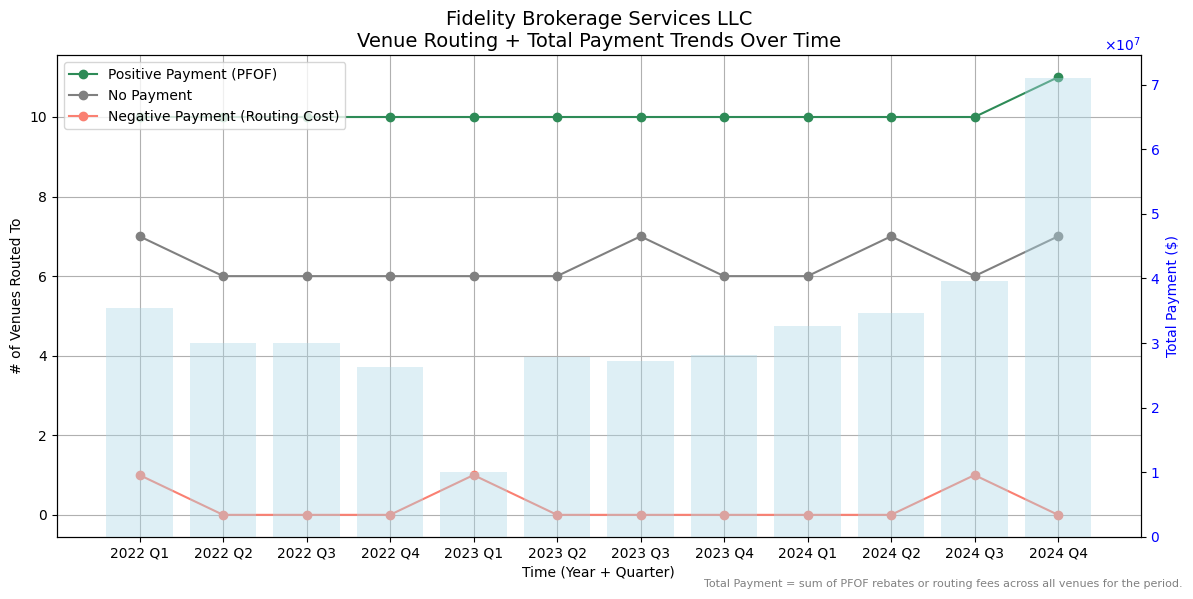

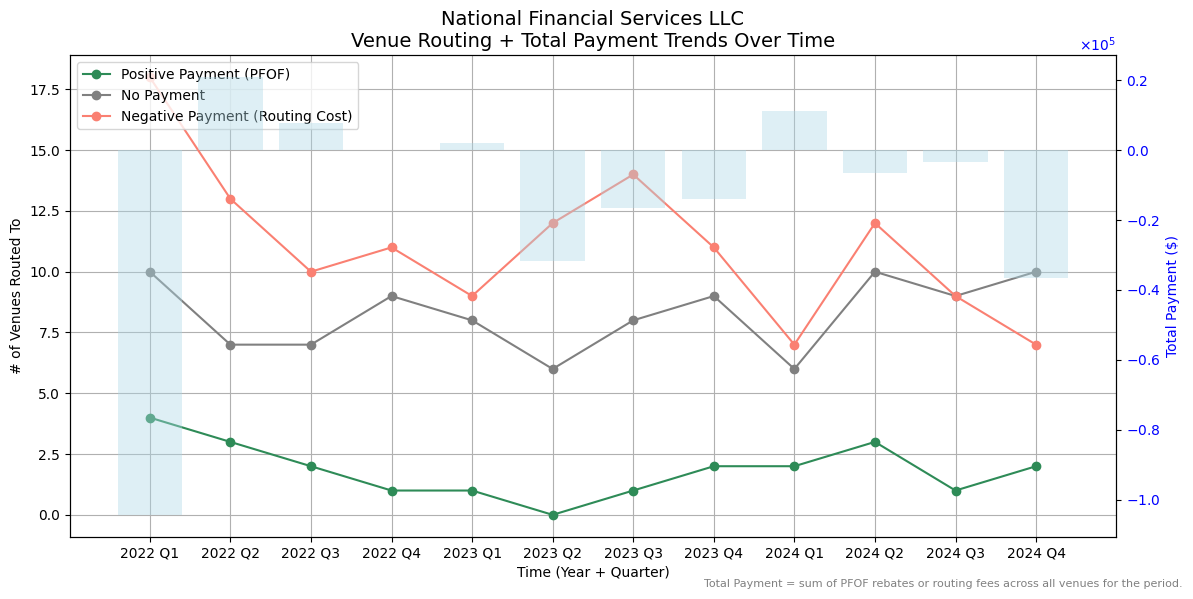

In [17]:
#venue routing & payment type
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.ticker import ScalarFormatter

def batch_plot_broker_venue_and_total_payment_trends_autoscale(df, save_fig=False, output_folder="./broker_plots/"):

    brokers = df['firm'].unique()

    for broker in brokers:
        broker_data = df[df['firm'] == broker].copy()
        broker_data['time_period'] = broker_data['year'].astype(str) + " " + broker_data['quarter']

        time_order = sorted(
            broker_data['time_period'].unique(),
            key=lambda x: (x.split()[0], x.split()[1])
        )

        positive, zero, negative, total_payment = [], [], [], []

        for time in time_order:
            subset = broker_data[broker_data['time_period'] == time]
            pos_count = subset[subset['total_pmt'] > 0]['venue_name'].nunique()
            zero_count = subset[subset['total_pmt'] == 0]['venue_name'].nunique()
            neg_count = subset[subset['total_pmt'] < 0]['venue_name'].nunique()
            total_pmt = subset['total_pmt'].sum()

            positive.append(pos_count)
            zero.append(zero_count)
            negative.append(neg_count)
            total_payment.append(total_pmt)

        # Plot
        fig, ax2 = plt.subplots(figsize=(12, 6))
        ax1 = ax2.twinx()

        bars = ax1.bar(time_order, total_payment, color='lightblue', alpha=0.4, label='Total Payment ($)')

        # Consistent scientific notation + readable axis label
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        ax1.yaxis.set_major_formatter(formatter)

        offset_text = ax1.yaxis.get_offset_text().get_text()
        if offset_text:
            ax1.set_ylabel(f"Total Payment ($, {offset_text})", color='blue')
        else:
            ax1.set_ylabel("Total Payment ($)", color='blue')

        ax1.tick_params(axis='y', labelcolor='blue')

        # Line plots for venues
        ax2.plot(time_order, positive, marker='o', label='Positive Payment (PFOF)', color='seagreen')
        ax2.plot(time_order, zero, marker='o', label='No Payment', color='gray')
        ax2.plot(time_order, negative, marker='o', label='Negative Payment (Routing Cost)', color='salmon')

        ax2.set_xlabel("Time (Year + Quarter)")
        ax2.set_ylabel("# of Venues Routed To", color='black')
        ax2.tick_params(axis='y')
        ax2.legend(loc='upper left')
        ax2.set_title(f"{broker}\nVenue Routing + Total Payment Trends Over Time", fontsize=14)

        plt.xticks(rotation=45)
        ax2.grid(True)
        fig.text(
            0.99, 0.01,
            "Total Payment = sum of PFOF rebates or routing fees across all venues for the period.",
            ha='right', va='bottom',
            fontsize=8, color='gray'
        )

        plt.tight_layout()

        plt.show()

batch_plot_broker_venue_and_total_payment_trends_autoscale(combined_quarterly)


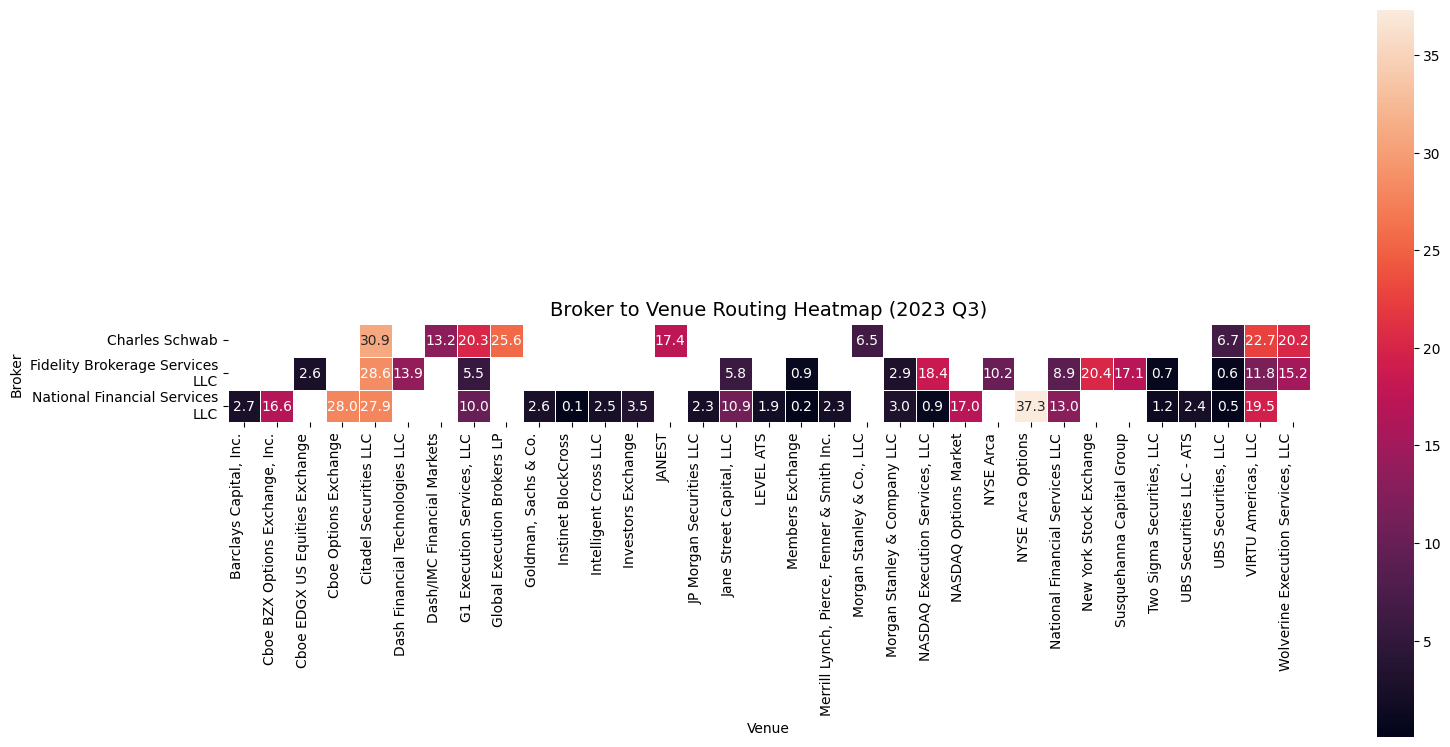

In [18]:
#broker to venue heatmap
import seaborn as sns
import matplotlib.pyplot as plt

def plot_broker_venue_heatmap_stdgroup_rawlabel(df, title_suffix=" (All Periods)"):

    # Create mapping: std_venue_name - most common venue_name
    mapping = (
        df.groupby('std_venue_name')['venue_name']
        .agg(lambda x: x.value_counts().index[0])  # most common label
    ).to_dict()

    # Group by broker + std_venue_name
    routing_matrix = df.groupby(['firm', 'std_venue_name'])['order_pct'].mean().unstack()

    # make labels look cleaner
    routing_matrix.index = routing_matrix.index.str.replace(' LLC', '\nLLC')

    # Make the axis have the real venue names
    routing_matrix.columns = [mapping.get(col, col) for col in routing_matrix.columns]

    # Sort for readability
    routing_matrix = routing_matrix.loc[sorted(routing_matrix.index), sorted(routing_matrix.columns)]

    # Plot
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(
        routing_matrix,
        annot=True, fmt=".1f",
        linewidths=0.5, square=True,
        cbar_kws={"shrink": 0.75}
    )

    ax.set_title(f"Broker to Venue Routing Heatmap{title_suffix}", fontsize=14)
    ax.set_xlabel("Venue")
    ax.set_ylabel("Broker")

    plt.xticks( ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

filtered = combined_quarterly[(combined_quarterly['year'] == "2023") & (combined_quarterly['quarter'] == "Q3")]
plot_broker_venue_heatmap_stdgroup_rawlabel(filtered, title_suffix=" (2023 Q3)")

#plot_broker_venue_heatmap_stdgroup_rawlabel(combined_quarterly)


# Liquidity Analysis

In [19]:
#HHI by broker, category, quarter, year
#HHI = sum of squared venue shares & scale
def calculate_hhi_by_category(df: pd.DataFrame, scale: int = 10000) -> pd.DataFrame:

    # Force order_pct into decimal form (handle cases if accidentally in %)
    temp_df = df.copy()
    temp_df['order_pct'] = temp_df['order_pct'] / 100 if temp_df['order_pct'].max() > 1 else temp_df['order_pct']

    def compute_hhi(group):
        shares = group['order_pct']
        return pd.Series({'hhi': (shares ** 2).sum() * scale})

    # Group by broker category quarter year
    hhi_df = (
        temp_df.groupby(['firm', 'category', 'year', 'quarter'])
        .apply(compute_hhi)
        .reset_index()
    )

    return hhi_df

hhi_category = calculate_hhi_by_category(combined_quarterly)
print(hhi_category.head())


             firm category  year quarter          hhi
0  Charles Schwab  Options  2022      Q1  2481.322733
1  Charles Schwab  Options  2022      Q2  2482.253289
2  Charles Schwab  Options  2022      Q3  2504.705056
3  Charles Schwab  Options  2022      Q4  2531.255056
4  Charles Schwab  Options  2023      Q1  2645.766489


<ipython-input-19-2a3ed0498d22>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_hhi)


In [20]:
hhi_category_SP500 = hhi_category[hhi_category['category'] == 'SP500']
hhi_category_options = hhi_category[hhi_category['category'] == 'Options']
hhi_category_NonSP500 = hhi_category[hhi_category['category'] == 'OtherStocks']

In [21]:
hhi_category_SP500

,firm,category,year,quarter,hhi
18,Charles Schwab,SP500,2022,Q1,2158.292289
19,Charles Schwab,SP500,2022,Q2,2138.061789
20,Charles Schwab,SP500,2022,Q3,2141.234944
21,Charles Schwab,SP500,2022,Q4,2119.577456
22,Charles Schwab,SP500,2023,Q1,2088.097400
23,Charles Schwab,SP500,2023,Q2,2107.132611
24,Charles Schwab,SP500,2023,Q3,2078.178822
25,Charles Schwab,SP500,2023,Q4,2005.575322
26,Charles Schwab,SP500,2024,Q1,1972.724736
51,Fidelity Brokerage Services LLC,SP500,2022,Q1,1547.791989


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hhi_over_time(hhi_df, category_name=None):

    # Create time axis
    hhi_df['time_period'] = hhi_df['year'].astype(str) + " " + hhi_df['quarter']

    plt.figure(figsize=(9, 6))
    ax = plt.gca()

    # Plot background bands
    ax.axhspan(0, 1500, facecolor='lightgreen', alpha=0.2)
    ax.axhspan(1500, 2500, facecolor='yellow', alpha=0.2)
    ax.axhspan(2500, 5000, facecolor='lightcoral', alpha=0.2)

    y_min = max(0, hhi_df['hhi'].min() - 250)
    y_max = hhi_df['hhi'].max() + 250
    ax.set_ylim(y_min, y_max)

    # Plot lines
    sns.lineplot(
        data=hhi_df,
        x='time_period',
        y='hhi',
        hue='firm',
        marker="o",
        ax=ax
    )

    plt.xticks(rotation=45)
    plt.ylabel("HHI")
    plt.xlabel("Time Period")

    title = "Broker Routing Concentration (HHI) Over Time"
    if category_name:
        title += f" - {category_name}"


    plt.title(title)
    plt.grid(True)


    # Only show one legend (for firm lines), not for bands
    handles, labels = ax.get_legend_handles_labels()
    # First len(firms) handles = line plots, ignore last 3 (bands)
    line_handles = handles[:len(hhi_df['firm'].unique())]
    line_labels = labels[:len(hhi_df['firm'].unique())]
    ax.legend(line_handles, line_labels, title='Broker')

    plt.tight_layout()
    plt.show()






**HHI Legend** <br>
HHI < 1500 : Unconcentrated <br>
HHI 1500 - 2500 : Moderately Concentrated <br>
HHI > 2500 : Highly Concentrated<br>
<br>
**Note:** Utilizes the average % of orders routed to venue (3 month average - based on quarter).

<ipython-input-22-01c106a5f1d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhi_df['time_period'] = hhi_df['year'].astype(str) + " " + hhi_df['quarter']


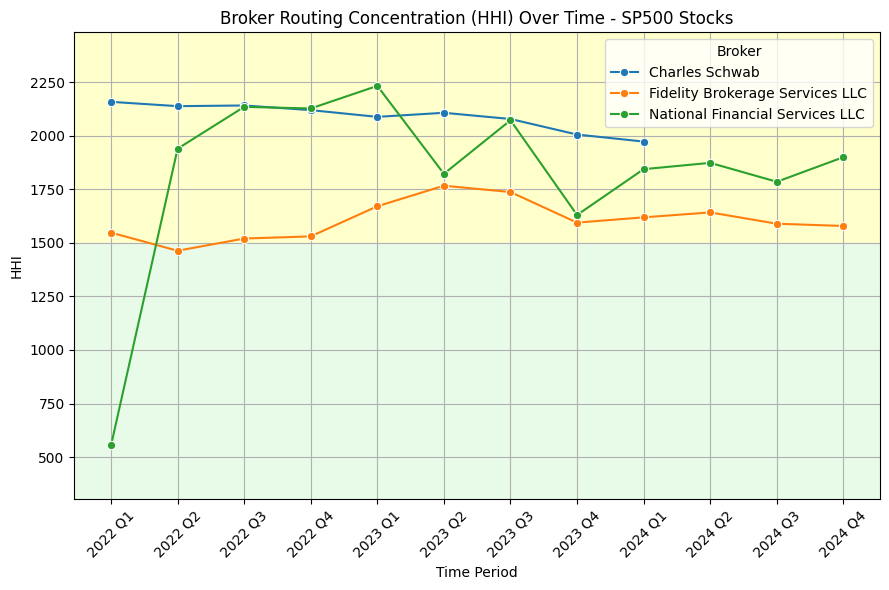

In [23]:
plot_hhi_over_time(hhi_category_SP500, category_name="SP500 Stocks")

**Findings SP500:**
<br><br>
Routing concentration for SP500 stocks were relatively consistent across brokers with all firms falling within the moderately concentrated range (yellow).
FBS maintained slight lower concentration levels compared to peers, implying a diversification of destination venues for SP500 stocks. This may suggest that the firm actively seeks the best execution.


<ipython-input-22-01c106a5f1d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhi_df['time_period'] = hhi_df['year'].astype(str) + " " + hhi_df['quarter']


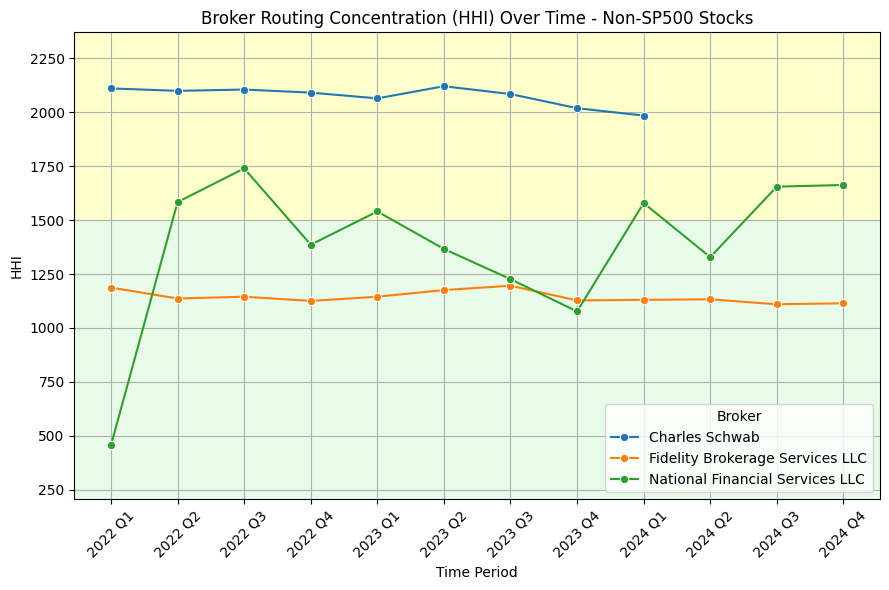

In [24]:
plot_hhi_over_time(hhi_category_NonSP500, category_name="Non-SP500 Stocks")

**Findings Non-SP500:** <br> <br>

Non-SP500 stocks show the biggest differences in broker routing practices. Fidelity demonstrated a relatively unconcentrated routing pattern which may be an effort to route to a diverse set of venues for less liquid stocks. This may suggest that the firm actively seeks the best execution.
<br> <br>
Schwab, on the other hand maintained a consistently high and stable HHI over time, indicating that it is reliant on a small number of execution venues.


<ipython-input-22-01c106a5f1d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhi_df['time_period'] = hhi_df['year'].astype(str) + " " + hhi_df['quarter']


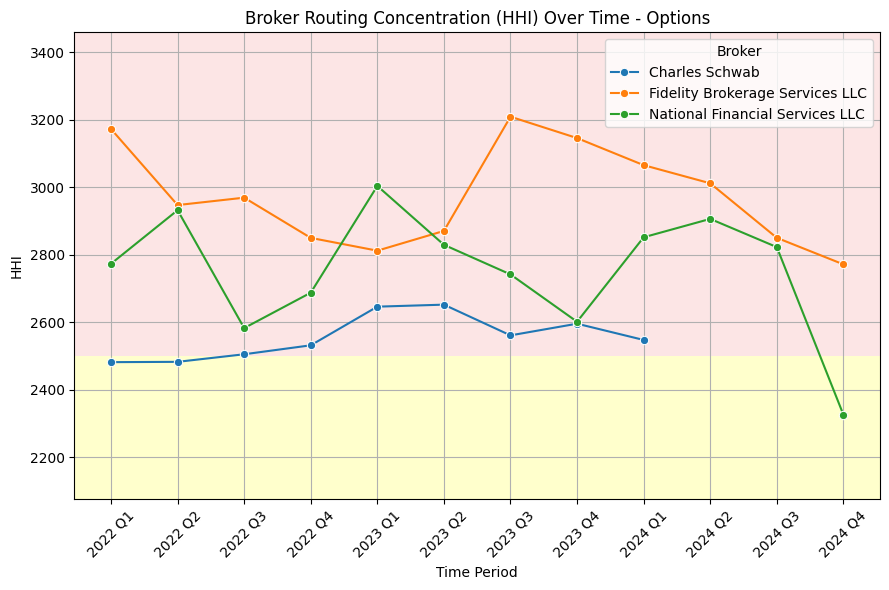

In [25]:
plot_hhi_over_time(hhi_category_options, category_name="Options")

**Findings Options:** <br> <br>
All 3 firms show consistently high concentration levels in options routing across all time periods. This is something I expepected since US option trading is fragmented across a limited number of venues so the broker flow would only be routed to a small set of dominant market makers. Because of this, deciding on what broker-dealer to use for options trading is less signifiance compared to equities.
<br> <br>
Interestingly, although both Schwab and Fidelity showed high concentration, both Fidelity broker-dealers may do business with fewer options loquidity providers or rely more on certain market-making relationships.



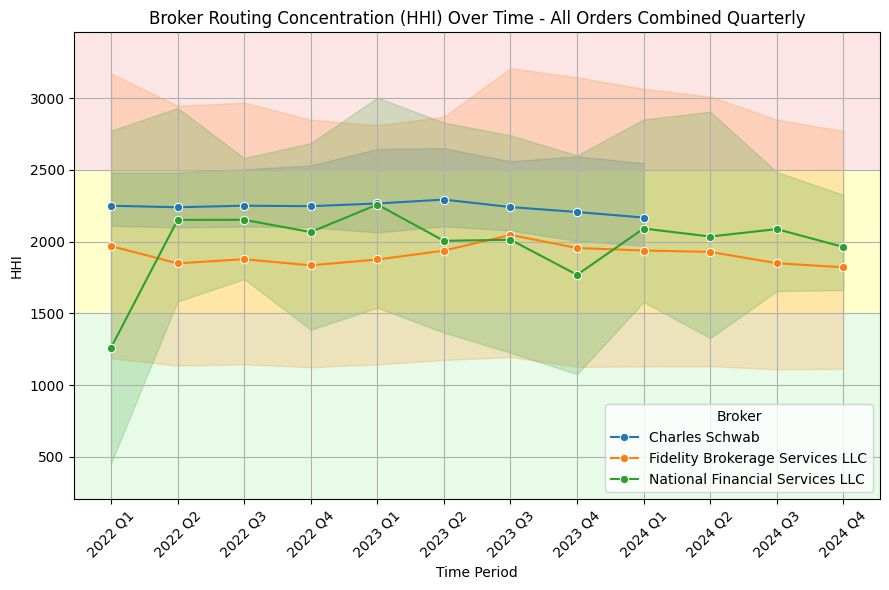

In [26]:
plot_hhi_over_time(hhi_category, category_name="All Orders Combined Quarterly")

**Next Steps Based on HHI:**
<br>
Based on the broker to venue behavior found in Non-SP500 stocks, I would like to investigate if concentration in certain venues are driven by PFOF incentives or by other unknown long-term routing agreements with liquidity providers. <br> <br>
**Action items -** link venue level routing patterns to payment data to see correlation of top venues and PFOF rebates.
